# pySCENIC protocol: PBMC10k 

# I. Basic Set Up

### i. Import dependencies

In [2]:
import pyscenic

In [4]:
import sys
print(sys.executable)


/u/home/p/priyalsh/.conda/envs/pyscenic/bin/python


In [10]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
import pyscenic
from MulticoreTSNE import MulticoreTSNE as TSNE
from dask.diagnostics import ProgressBar
from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell
import seaborn as sns



from multiprocessing import cpu_count
from operator import concat
from typing import Callable, Sequence, Type, TypeVar

from boltons.iterutils import chunked_iter
from ctxcore.genesig import GeneSignature, Regulon
from ctxcore.rnkdb import MemoryDecorator, RankingDatabase
from dask import delayed
from dask.dataframe import from_delayed
from dask.distributed import Client, LocalCluster
from multiprocessing_on_dill.connection import Pipe
from multiprocessing_on_dill.context import Process

/u/home/p/priyalsh/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [ ]:
# Get your SCRATCH directory from the environment
scratch_dir = os.environ["SCRATCH"]

# Change the working directory
os.chdir(scratch_dir)

# Verify
print("Now working in:", os.getcwd())

In [3]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

-----
anndata     0.10.9
scanpy      1.10.3
-----
MulticoreTSNE               NA
PIL                         11.3.0
asciitree                   NA
asttokens                   NA
attr                        25.3.0
backports                   NA
boltons                     NA
cffi                        1.17.1
click                       8.1.8
cloudpickle                 3.1.1
colorama                    0.4.6
comm                        0.2.3
ctxcore                     0.2.0
cycler                      0.12.1
cython_runtime              NA
cytoolz                     1.0.1
dask                        2024.2.1
dateutil                    2.9.0.post0
debugpy                     1.8.16
decorator                   5.2.1
dill                        0.3.9
distributed                 2024.2.1
exceptiongroup              1.2.2
executing                   2.2.0
frozendict                  2.4.6
fsspec                      2025.2.0
h5py                        3.13.0
igraph                      0

/u/home/p/priyalsh/.local/lib/python3.9/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


In [4]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 20

### ii. Setting working variables

In [12]:
# Base directory for today's run
base_dir = "/u/scratch/p/priyalsh/dropbox_oct6/t_cell_data_oct6.h5ad"

# Path to unfiltered loom file (will be created later)
f_loom_path_unfilt = f"{base_dir}/unfiltered_cd4_rest_oct6.loom"

# Path to loom file with basic filtering applied
f_loom_path_scenic = f"{base_dir}/filtered_scenic_cd4_rest_oct6.loom"

# Clone of the original .h5ad file for this subset
f_anndata_path = f"{base_dir}/t_cell_data_oct6.h5ad"

# Path to pyscenic output
f_pyscenic_output = f"{base_dir}/pyscenic_output_cd4_rest_oct6.loom"

# Loom output, generated from Scanpy + pySCENIC integration
f_final_loom = f"{base_dir}/pbmc10k_scenic_integrated-output_oct6.loom"


### iii. Expression Data Import 

In [12]:
adata = sc.read('/u/home/p/priyalsh/t_cell_data.h5ad')

In [13]:
print(adata)           # Summary of cells × genes
print(adata.obs.head())  # Cell metadata
print(adata.var.head())  # Gene metadata

AnnData object with n_obs × n_vars = 47726 × 58828
    obs: 'stimulation', 'cd_status'
                 stimulation cd_status
ACCCACTTCTCGATGA        rest       CD8
GATCAGTTCAAACCGT         act       CD4
TGACTTTCAATGGATA        rest       CD8
CAAGATCTCTTGGGTA        rest       CD8
CATCCACGTCACCTAA        rest       CD8
Empty DataFrame
Columns: []
Index: [TIGD2, DMWD, C6orf3, SPIN2A, AC009133.12]


In [16]:
import numpy as np

# Compute total counts per cell from the count matrix
adata.obs['total_counts'] = np.array(adata.X.sum(axis=1)).flatten()


In [19]:
adata.obs

,CD_Status,Stimulation,nGene,nUMI,n_genes,percent_mito,leiden,total_counts
CellID,,,,,,,,
GATCAGTTCAAACCGT,CD4,act,3732,10614,3732,0.054456,11,788.866995
TGACTTTCAATGGATA,CD8,rest,3065,9883,3065,0.060103,11,681.914204
CAAGATCTCTTGGGTA,CD8,rest,2752,9778,2752,0.027920,7,192.977478
CATCCACGTCACCTAA,CD8,rest,2673,8018,2673,0.030057,7,315.080906
GTTCGGGAGGTGATAT,CD8,act,3090,7922,3090,0.051755,11,734.421768
...,...,...,...,...,...,...,...,...
GCGCCAACACCGCTAG,CD8,act,617,1065,617,0.092019,10,29.984666
CCTACACGTCTCCCTA,CD4,act,543,1056,543,0.017045,10,28.252846
TCGCGAGCAGGAATCG,CD4,act,514,1051,514,0.037108,10,-129.092231


In [ ]:
row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = {
    "CellID": adata.obs.index.values.astype(str),
    "CD_Status": adata.obs["CD_Status"].astype(str).values,
    "Stimulation": adata.obs["Stimulation"].astype(str).values,
    "nGene": np.array((adata.X.T > 0).sum(axis=0)).flatten(),
    "nUMI":  np.array(adata.X.T.sum(axis=0)).flatten(),
}

lp.create(f_loom_path_unfilt, adata.X.T, row_attrs, col_attrs)

# II. Preprocessing

Computers pySCENIC filtering thresholds to exclude weakly expressed genes

In [33]:
# read unfiltered data from a loom file
adata = sc.read_loom( f_loom_path_unfilt )

In [21]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: -1118.1612894611426  -  8.582451416216941e-11
Number of cells in which each gene is detected: 173  -  27383


In [22]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)


minCountsPerGene:  1428.8999999999999
minSamples:  476.3


This code adds per-cell QC metrics: it counts the number of genes expressed in each cell, then calculates the fraction of total counts that comes from MITOCHONDRIAL GENES. High mitrochondrial fractions can indicate stressed or dying cells

In [23]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)

# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('MT-')

# for each cell, compute the frrestion of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)


Diagnostic Plots (pre-filtering): Same distributions but on a smaller scale

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual pre-filtering plot data)
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(x, y, label='Raw gene expression')
plt.title("Pre-Filtering Gene Expression Distribution — All Cell Types (Oct 6)")
plt.xlabel("Sample Index")
plt.ylabel("Expression Level")
plt.legend()
plt.tight_layout()

# Define save path with a descriptive, self-explanatory filename
save_path = "/u/scratch/p/priyalsh/dropbox_oct6/pre_filtering_gene_expression_all_cells_oct6.png"

# Save the figure as a PNG
plt.savefig(save_path, dpi=300)
plt.close()

print(f"✅ Pre-filtering plot saved to: {save_path}")


✅ Pre-filtering plot saved to: /u/scratch/p/priyalsh/dropbox_oct6/pre_filtering_gene_expression_all_cells_oct6.png


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

# Data and binning parameters
x = adata.obs['percent_mito']
x_lowerbound = [0.0, 0.07]
x_upperbound = [0.10, 0.3]
nbins = 100

# Histograms
sns.histplot(x, ax=ax1, bins=nbins)
sns.histplot(x, ax=ax2, bins=int(nbins / (x_lowerbound[1] - x_lowerbound[0])))
sns.histplot(x, ax=ax3, bins=int(nbins / (x_upperbound[1] - x_upperbound[0])))

# Zoomed panels
ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
ax3.set_xlim(x_upperbound[0], x_upperbound[1])

# Axis labels
for ax in (ax1, ax2, ax3):
    ax.set_xlabel('')

# Subplot titles
ax1.set_title('Percent Mito — Full Range')
ax2.set_title('Percent Mito — Lower Bound')
ax3.set_title('Percent Mito — Upper Bound')

# Shared labels
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Mitochondrial Read Fraction per Cell', ha='center', va='center', size='x-large')

# Overall title
fig.suptitle("Pre-Filtering Distribution of Mitochondrial Read Fraction — All Cell Types (Oct 6)",
             fontsize='x-large', y=1.05)

fig.tight_layout()

# Save figure
save_path = "/u/scratch/p/priyalsh/dropbox_oct6/pre_filtering_percent_mito_distribution_all_cells_oct6.png"
fig.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close(fig)

print(f"✅ Pre-filtering percent_mito histogram panel saved to: {save_path}")


✅ Pre-filtering percent_mito histogram panel saved to: /u/scratch/p/priyalsh/dropbox_oct6/pre_filtering_percent_mito_distribution_all_cells_oct6.png


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

# Extract data
x = adata.obs['percent_mito']
x_lowerbound = [0.0, 0.07]
x_upperbound = [0.10, 0.3]
nbins = 100

# Plot histograms
sns.histplot(x, ax=ax1, bins=nbins)
sns.histplot(x, ax=ax2, bins=int(nbins / (x_lowerbound[1] - x_lowerbound[0])))
sns.histplot(x, ax=ax3, bins=int(nbins / (x_upperbound[1] - x_upperbound[0])))

# Set zoomed-in x-limits for second and third panels
ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
ax3.set_xlim(x_upperbound[0], x_upperbound[1])

# Axis labels and titles
for ax in (ax1, ax2, ax3):
    ax.set_xlabel('')

ax1.set_title('Percent Mito — Full Range')
ax2.set_title('Percent Mito — Lower Bound')
ax3.set_title('Percent Mito — Upper Bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Mitochondrial Read Fraction per Cell', ha='center', va='center', size='x-large')

# Updated figure title to reflect all cell types
fig.suptitle("Pre-Filtering Distribution of Mitochondrial Read Fraction — All Cell Types (Oct 6)", 
             fontsize='x-large', y=1.05)

fig.tight_layout()

# Updated save path with descriptive filename
save_path = "/u/scratch/p/priyalsh/dropbox_oct6/pre_filtering_percent_mito_distribution_all_cells_oct6.png"
fig.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close(fig)

print(f"✅ Pre-filtering mitochondrial read fraction plot saved to: {save_path}")


✅ Pre-filtering mitochondrial read fraction plot saved to: /u/scratch/p/priyalsh/dropbox_oct6/pre_filtering_percent_mito_distribution_all_cells_oct6.png


,CD_Status,Stimulation,nGene,nUMI,n_genes,percent_mito
CellID,,,,,,
ACCCACTTCTCGATGA,CD8,rest,4641,14704,4641,0.050598
GATCAGTTCAAACCGT,CD4,act,3732,10614,3732,0.054456
TGACTTTCAATGGATA,CD8,rest,3065,9883,3065,0.060103
CAAGATCTCTTGGGTA,CD8,rest,2752,9778,2752,0.027920
CATCCACGTCACCTAA,CD8,rest,2673,8018,2673,0.030057
...,...,...,...,...,...,...
GCGCCAACACCGCTAG,CD8,act,617,1065,617,0.092019
CCTACACGTCTCCCTA,CD4,act,543,1056,543,0.017045
TCGCGAGCAGGAATCG,CD4,act,514,1051,514,0.037108


In [28]:
import matplotlib.pyplot as plt
import scanpy as sc

# Pre-filtering violin plots for all cell types
sc.pl.violin(
    adata,
    ['n_genes', 'nUMI', 'percent_mito'],
    jitter=0.4,
    multi_panel=True,
    show=False  # prevent immediate display so we can edit & save
)

# Add a clear figure title
plt.suptitle("Pre-Filtering Violin Plots — All Cell Types (Oct 6)", fontsize='x-large', y=1.02)

# Adjust layout
plt.tight_layout()

# Define save path with descriptive, self-explanatory filename
save_path = "/u/scratch/p/priyalsh/dropbox_oct6/pre_filtering_violin_qc_all_cells_oct6.png"

# Save as PNG
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"✅ Pre-filtering violin QC plot (all cell types) saved to: {save_path}")


✅ Pre-filtering violin QC plot (all cell types) saved to: /u/scratch/p/priyalsh/dropbox_oct6/pre_filtering_violin_qc_all_cells_oct6.png


In [29]:
import matplotlib.pyplot as plt
import scanpy as sc

# Pre-filtering scatter plot: nUMI vs nGene, colored by percent_mito
sc.pl.scatter(
    adata,
    x='nUMI',
    y='nGene',
    color='percent_mito',
    show=False  # allows us to modify & save the figure
)

# Add descriptive title
plt.title("Pre-Filtering Scatter Plot — All Cell Types (Oct 6)", fontsize='x-large')

# Adjust layout
plt.tight_layout()

# Define save path with a self-explanatory filename
save_path = "/u/scratch/p/priyalsh/dropbox_oct6/pre_filtering_scatter_nUMI_nGene_percent_mito_all_cells_oct6.png"

# Save as PNG
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"✅ Pre-filtering scatter plot saved to: {save_path}")


/tmp/ipykernel_5419/773307757.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Pre-filtering scatter plot saved to: /u/scratch/p/priyalsh/dropbox_oct6/pre_filtering_scatter_nUMI_nGene_percent_mito_all_cells_oct6.png


### i. filtering

filter_cells(..., min_genes=200) keeps only cells that express at least 200 genes (removing poor-quality or empty droplets).

filter_genes(..., min_cells=3) keeps only genes expressed in at least 3 cells (removing very rare/noisy genes).

In [44]:
# initial cuts
sc.pp.filter_cells(adata, min_genes=200 )
sc.pp.filter_genes(adata, min_cells=3 )

filtered out 27246 genes that are detected in less than 3 cells


In [45]:
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.15, :]

Diagnostic Plots (post Filtering)

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots for post-filtering QC panel
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

# Plot histograms
sns.histplot(adata.obs['nGene'], ax=ax1, bins=100)
sns.histplot(adata.obs['nUMI'], ax=ax2, bins=100)
sns.histplot(adata.obs['percent_mito'], ax=ax3, bins=100)

# Subplot titles
ax1.set_title('Number of Genes Expressed per Cell')
ax2.set_title('Counts (nUMI) per Cell')
ax3.set_title('Mitochondrial Read Fraction per Cell')

# Shared y-axis label
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

# Descriptive figure title
fig.suptitle("Post-Filtering QC Metrics — All Cell Types (Oct 6)", fontsize='x-large', y=1.05)

# Adjust layout
fig.tight_layout()

# Save the figure as a PNG with a descriptive, self-explanatory filename
save_path = "/u/scratch/p/priyalsh/dropbox_oct6/post_filtering_qc_panel_all_cells_oct6.png"
fig.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close(fig)

print(f"✅ Post-filtering QC panel saved to: {save_path}")


✅ Post-filtering QC panel saved to: /u/scratch/p/priyalsh/dropbox_oct6/post_filtering_qc_panel_all_cells_oct6.png


In [47]:
import matplotlib.pyplot as plt
import scanpy as sc

# Post-filtering violin plots for all cell types
sc.pl.violin(
    adata,
    ['nGene', 'nUMI', 'percent_mito'],
    jitter=0.4,
    multi_panel=True,
    show=False
)

# Add descriptive title
plt.suptitle("Post-Filtering Violin Plots — All Cell Types (Oct 6)", fontsize='x-large', y=1.02)

# Adjust layout
plt.tight_layout()

# Define save path with clear naming
save_path = "/u/scratch/p/priyalsh/dropbox_oct6/post_filtering_violin_qc_all_cells_oct6.png"

# Save figure
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"✅ Post-filtering violin QC plot saved to: {save_path}")


✅ Post-filtering violin QC plot saved to: /u/scratch/p/priyalsh/dropbox_oct6/post_filtering_violin_qc_all_cells_oct6.png


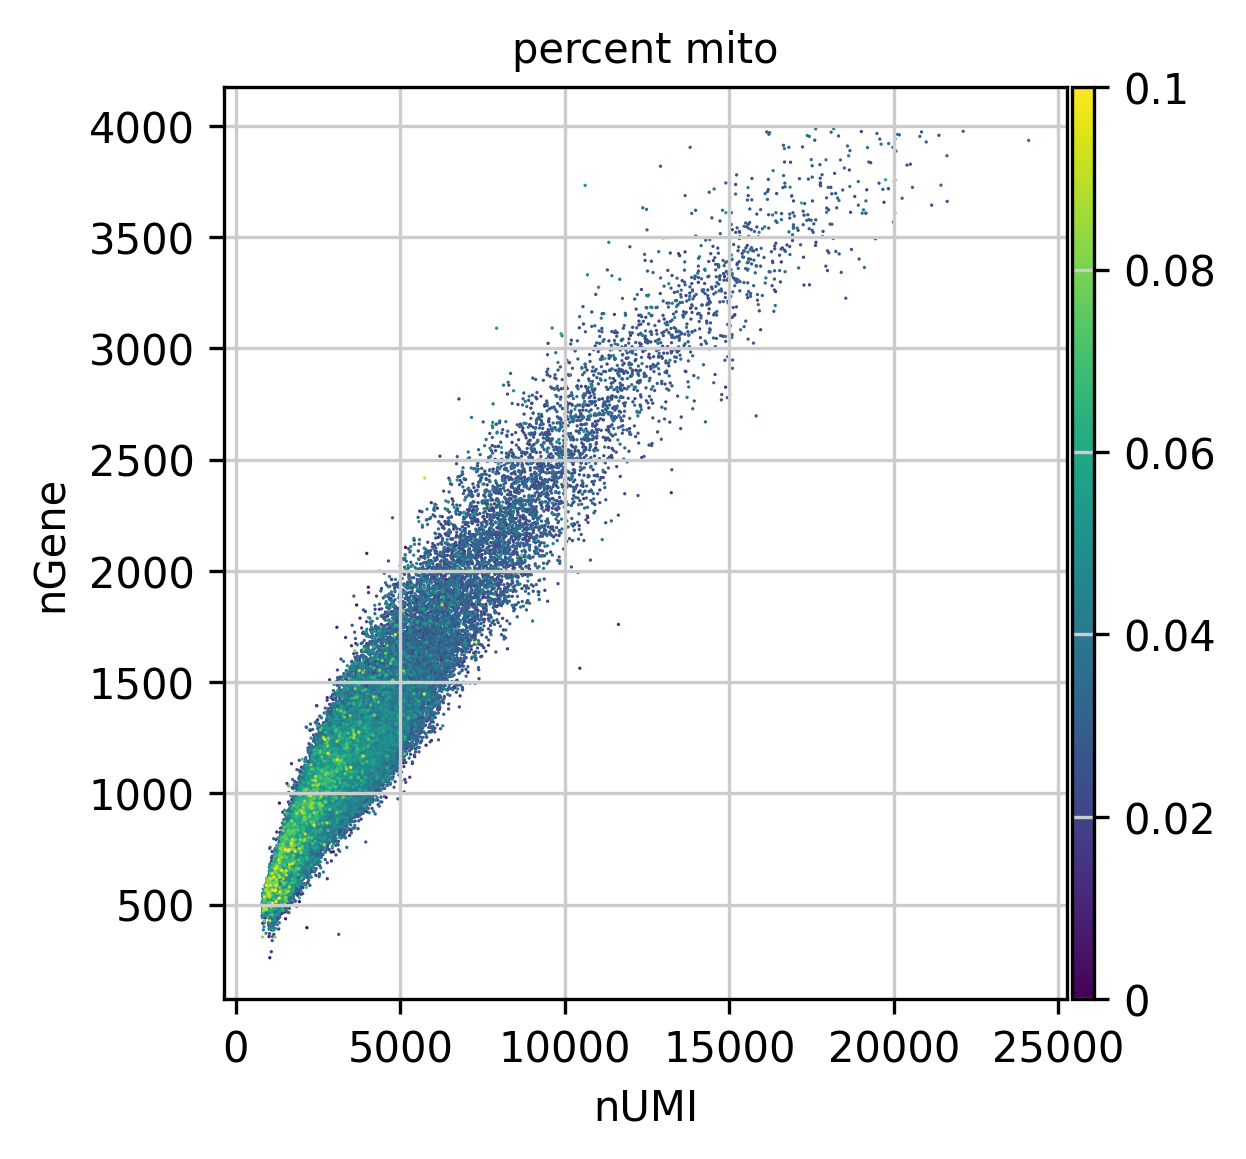

In [48]:
sc.pl.scatter(adata, x='nUMI', y='nGene', color='percent_mito')

### ii. finalize filters and write to loom file

In [50]:
adata.write(f_anndata_path)

In [51]:
row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = {
    "CellID": adata.obs.index.values.astype(str),
    "CD_Status": adata.obs["CD_Status"].astype(str).values,
    "Stimulation": adata.obs["Stimulation"].astype(str).values,
    "nGene": np.array((adata.X.T > 0).sum(axis=0)).flatten(),
    "nUMI":  np.array(adata.X.T.sum(axis=0)).flatten(),
}

lp.create(f_loom_path_scenic, adata.X.T, row_attrs, col_attrs)

# III. Further preprocessing

In [30]:
#Save a copy of the raw data
adata.raw = adata

This step normalizes the data by sequencing depth: it rescales each cell’s total counts so that every cell has the same total (10,000 reads). This corrects for differences in library size, making gene expression levels comparable across cells.

In [31]:
# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_total(adata, target_sum=1e4)

/u/home/p/priyalsh/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


This applies a logarithmic transformation to the expression values (computes log(1 + x) for each count). It reduces the impact of very highly expressed genes and makes the data more normally distributed, which helps many downstream analyses.

In [32]:
# log transform the data.
sc.pp.log1p(adata)

/u/home/p/priyalsh/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:385: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


This code identifies and visualizes the highly variable genes (HVGs):

sc.pp.highly_variable_genes(...) selects genes with expression that is neither too low nor too high, but shows strong variability across cells (using thresholds on mean expression and dispersion).

sc.pl.highly_variable_genes(...) plots the results, showing which genes are considered HVGs for downstream analyses like PCA and clustering.

Very similar graphs in terams of selecting highly variable genes

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


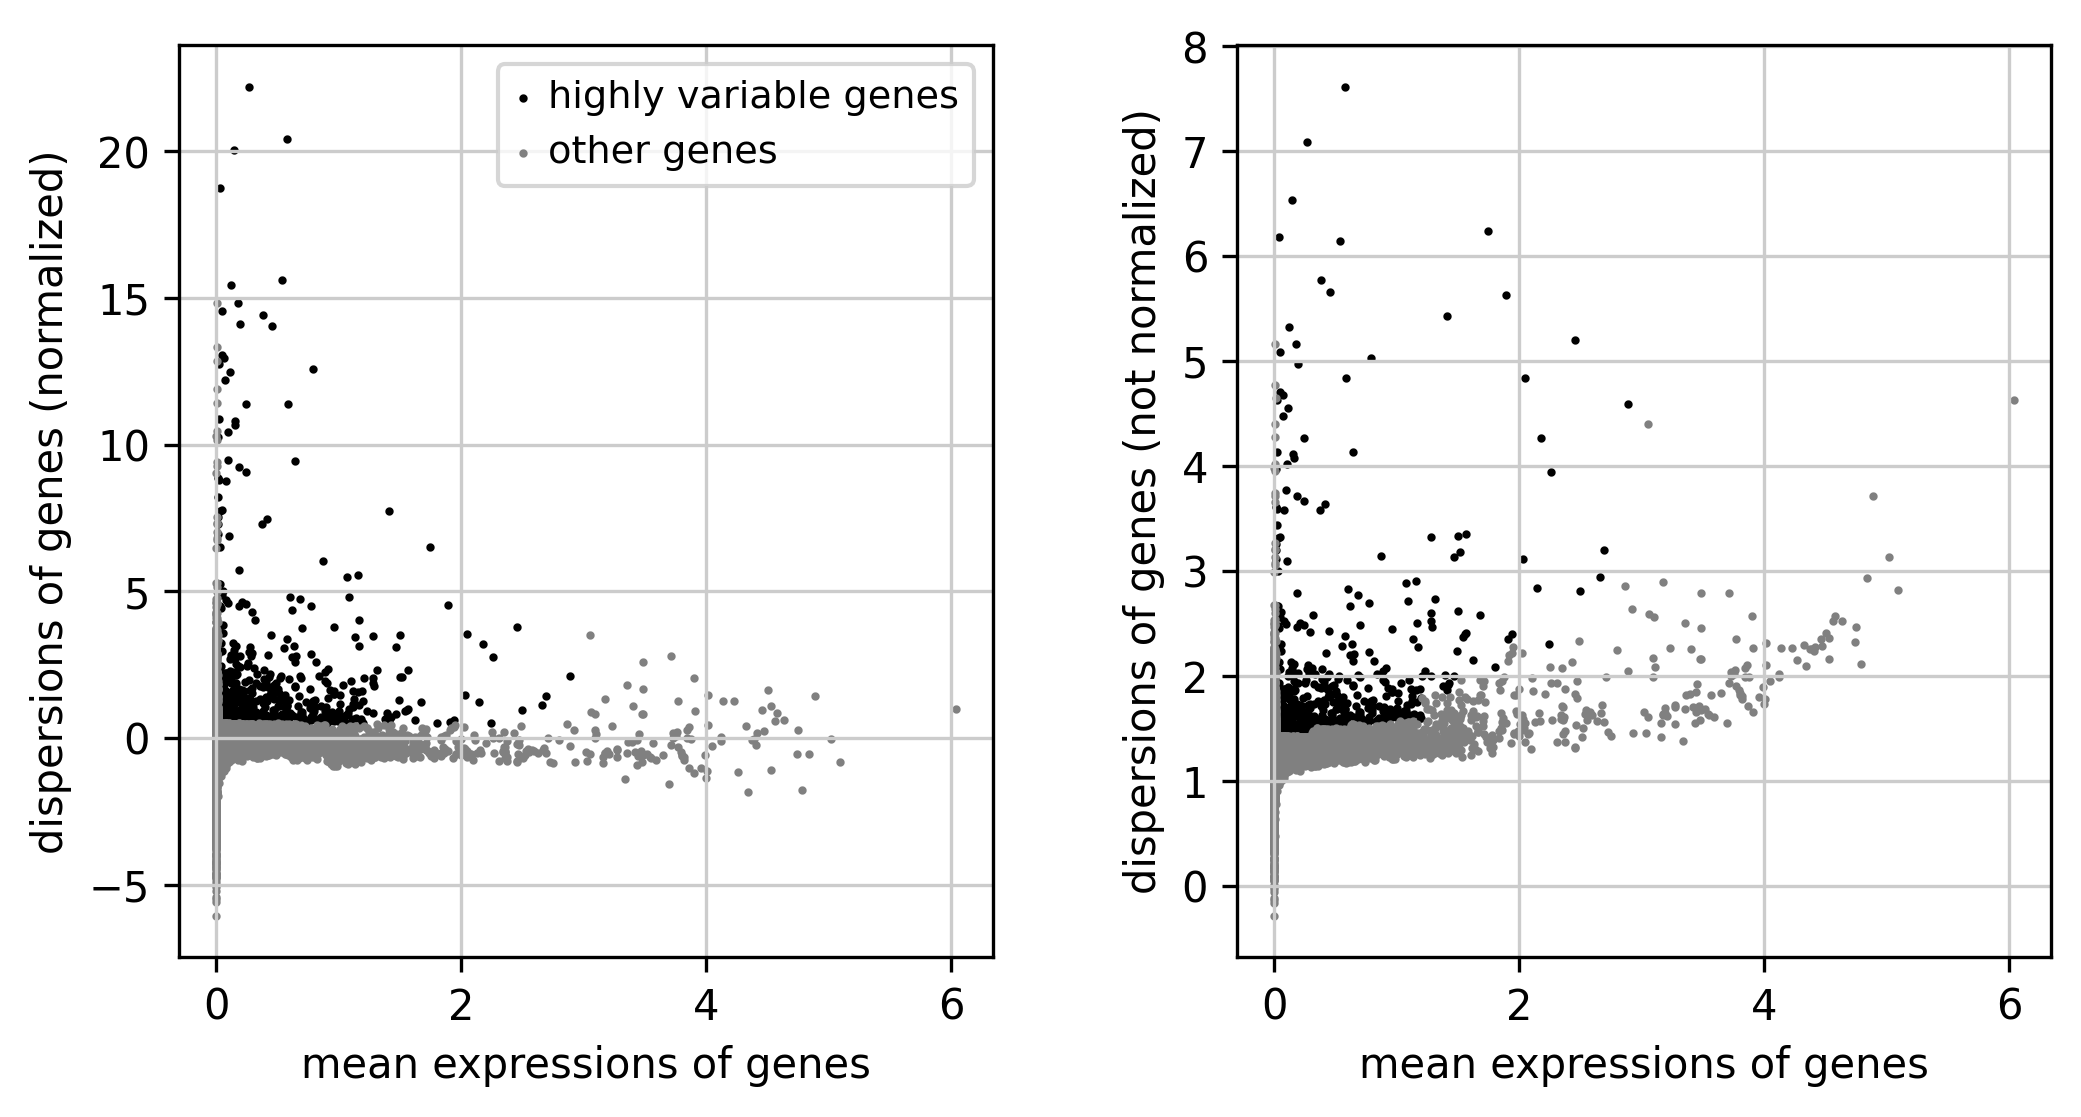

In [55]:
# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [56]:
# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

In [57]:
# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['nUMI', 'percent_mito'] ) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)

regressing out ['nUMI', 'percent_mito']


/u/home/p/priyalsh/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:668: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    sparse input is densified and may lead to high memory use
    finished (0:00:34)


In [58]:
# update the anndata file:
adata.write( f_anndata_path )

## i. 1PCA

This code runs and visualizes PCA (Principal Component Analysis) on the single-cell data:

sc.tl.pca(...) computes principal components, reducing the high-dimensional gene expression matrix into a smaller set of orthogonal axes that capture most of the variance.

computing PCA
    with n_comps=50
    finished (0:00:06)


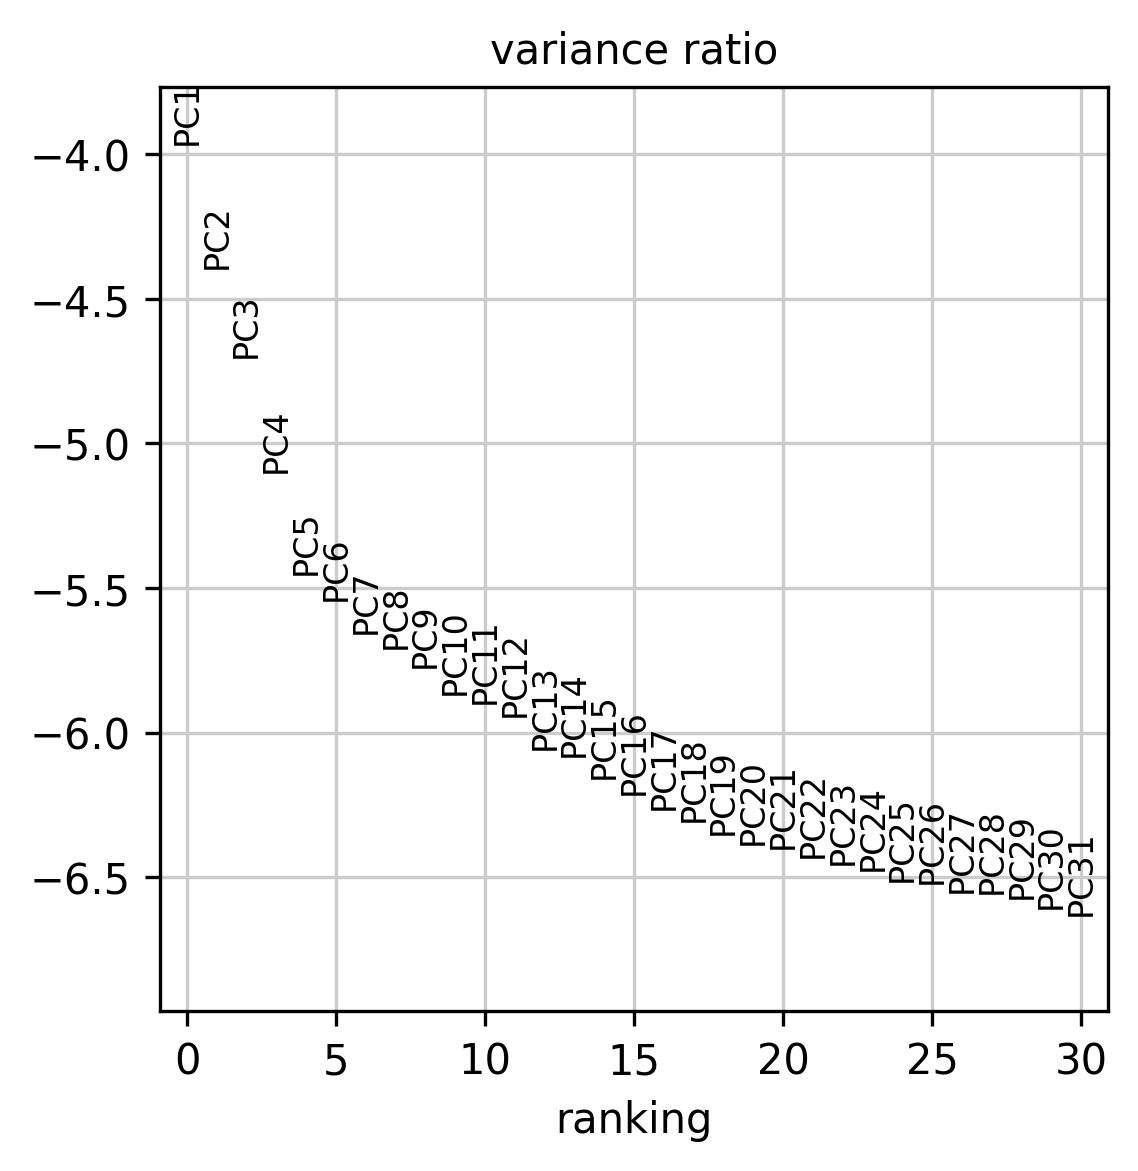

In [59]:
# adata = sc.read_h5ad( f_anndata_path )

# principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
# adata.write( f_anndata_path )

## ii. Visualization of highly variable genes

In [ ]:
# neighborhood graph of cells (determine optimal number of PCs here)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
# compute UMAP
sc.tl.umap(adata)
# tSNE
tsne = TSNE( n_jobs=20 )
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )
adata.write( f_anndata_path )

## iii. Clustering

running Leiden clustering


/tmp/ipykernel_301/2757486123.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.4, random_state=42)


    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:27)


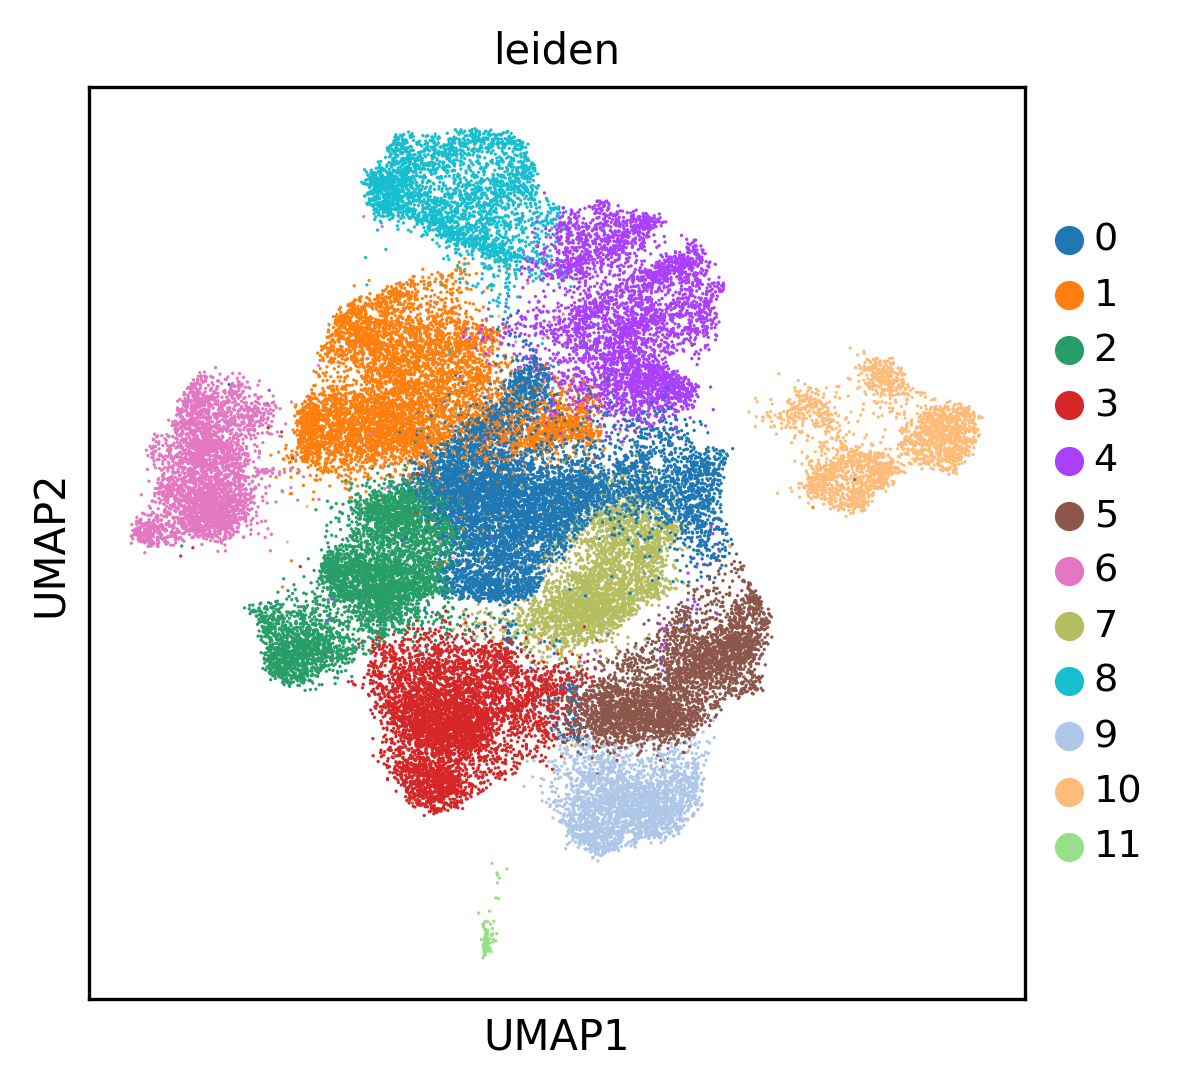

In [61]:
# Cluster the neighborhood graph with a fixed seed
sc.tl.leiden(adata, resolution=0.4, random_state=42)

# Visualize the clusters
sc.pl.umap(adata, color=['leiden'])

In [1]:
## Clustering is kind of similar across both

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


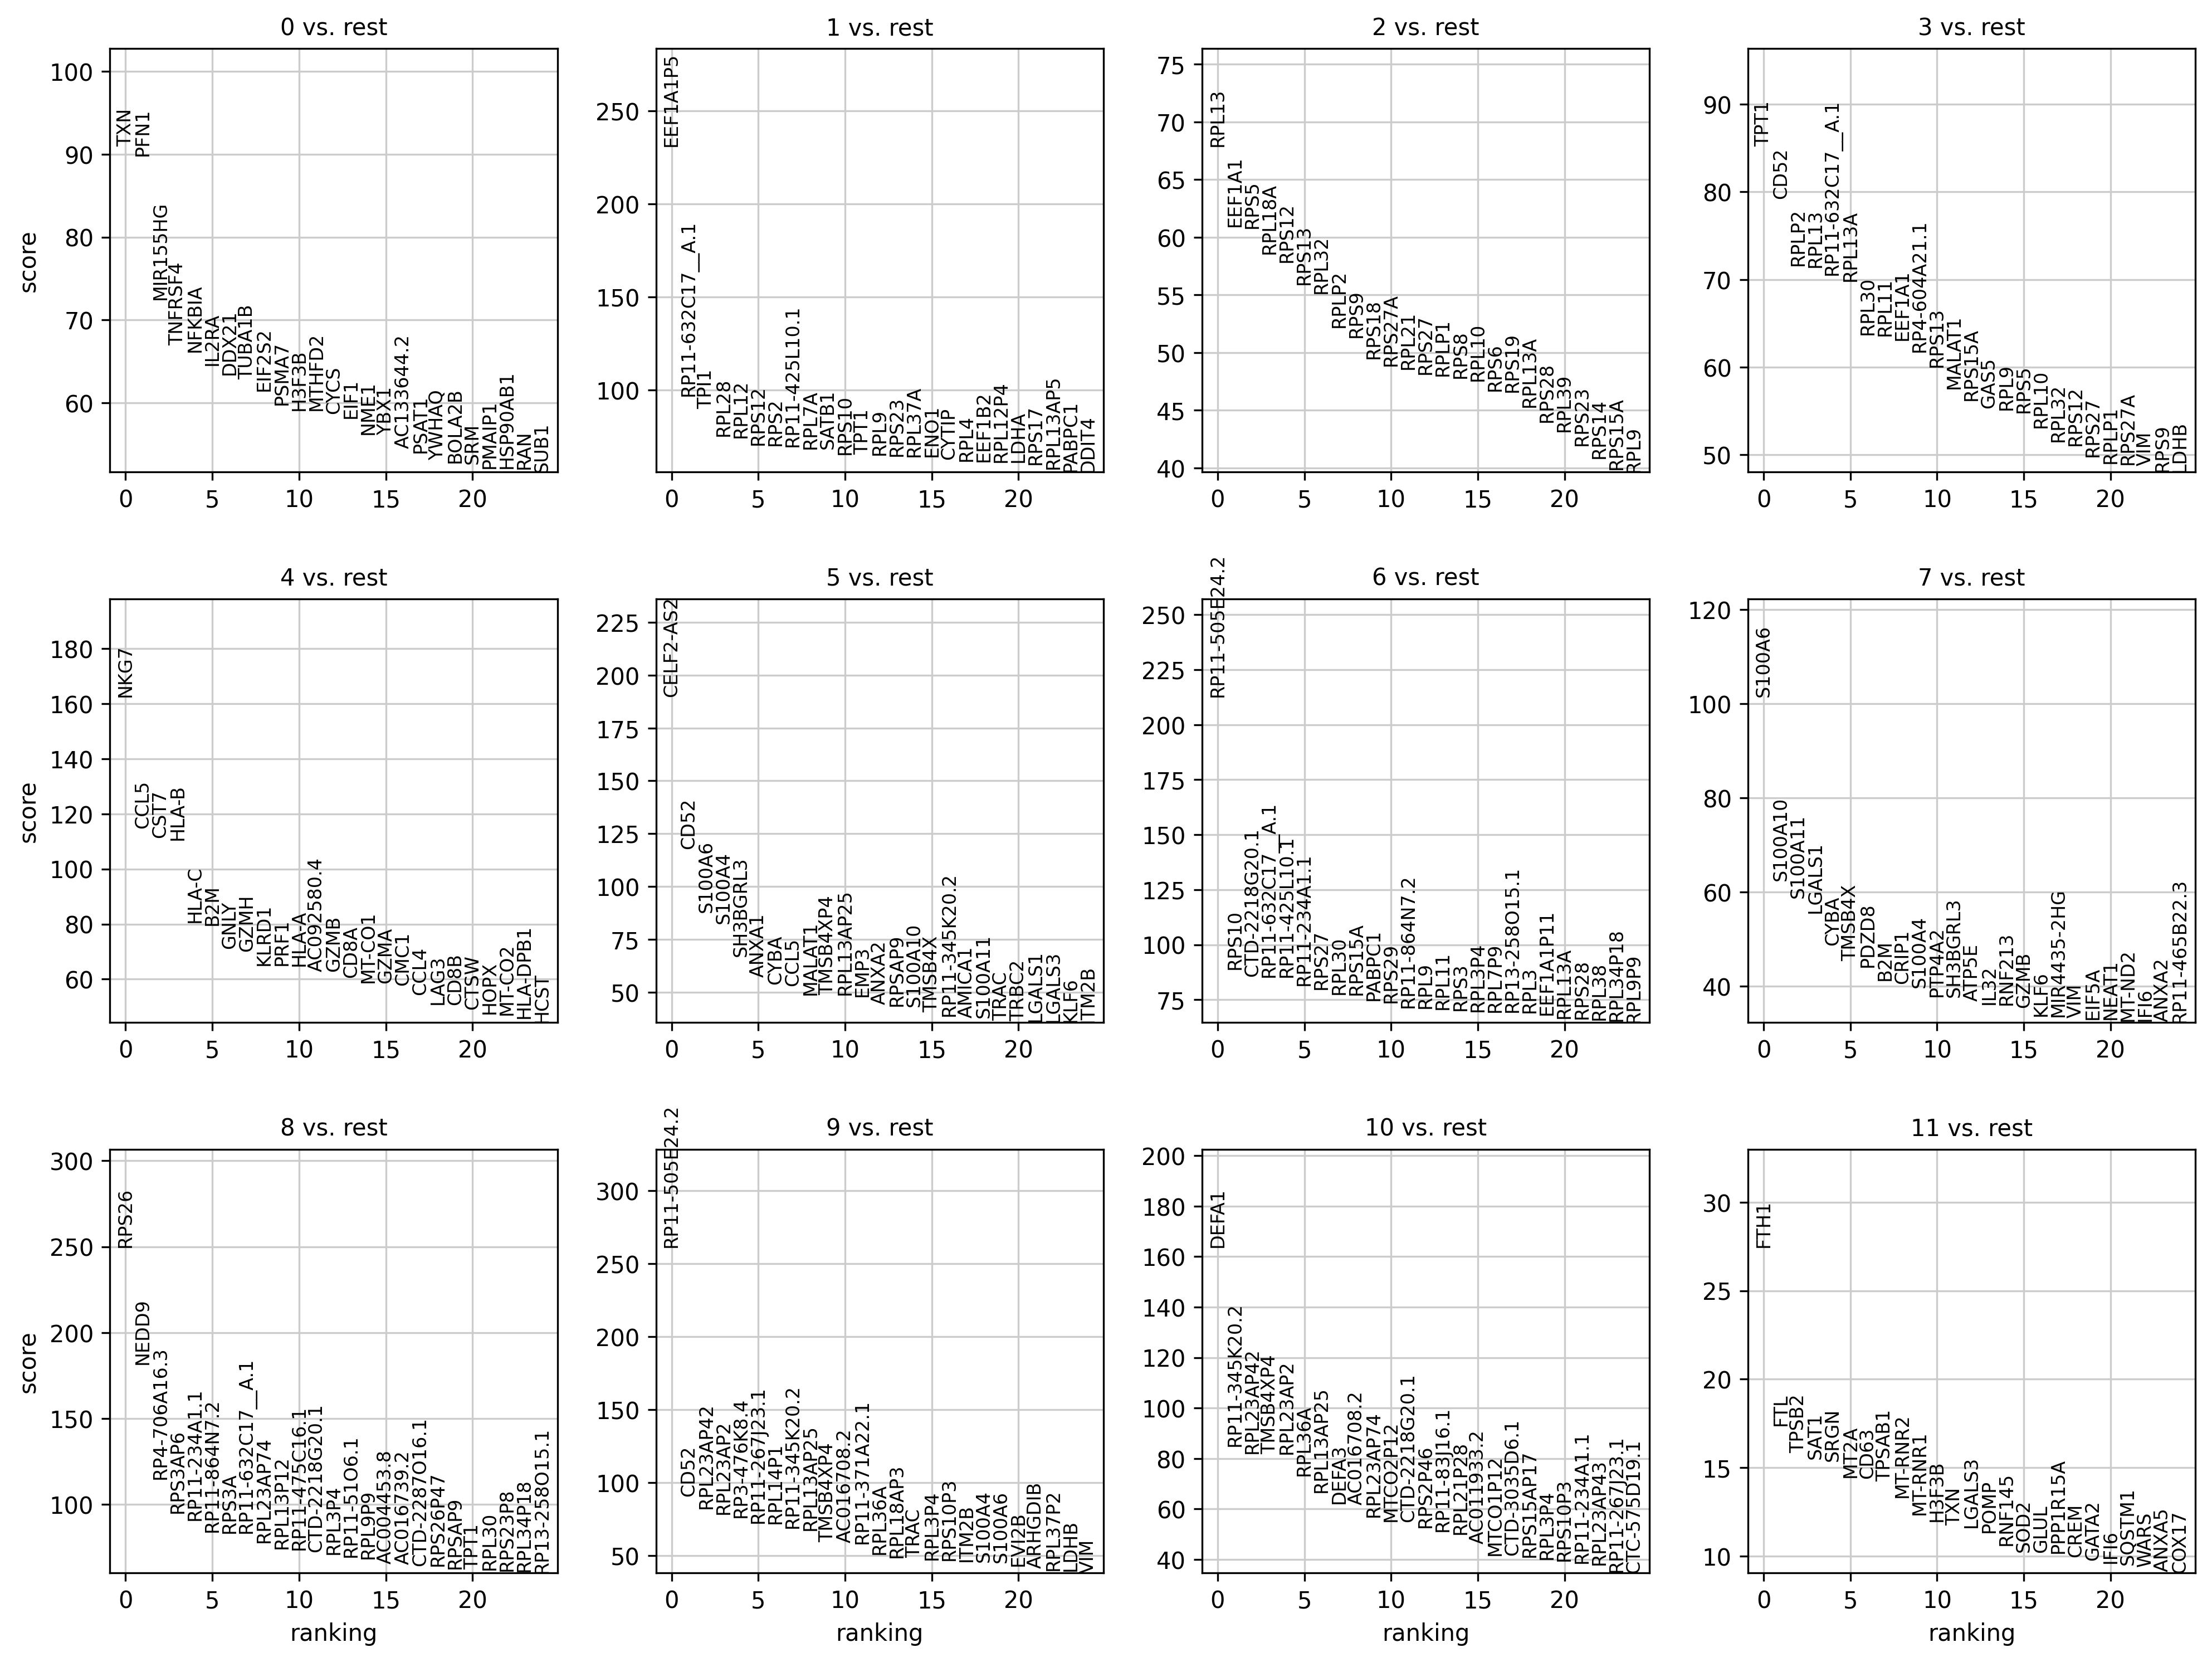

In [62]:
# find marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
adata.write( f_anndata_path )

In [63]:
import loompy
# Prepare row attributes (usually genes or features)
row_attrs = {
    "Gene": np.array(adata.var.index),  # List of gene names or feature identifiers
}

# Prepare column attributes (usually cells)
col_attrs = {
    "CellID": np.array(adata.obs.index),  # List of cell IDs
    "Stimulation": np.array(adata.obs['Stimulation']),  # Assuming you have a 'stimulation' column
    "CD_Status": np.array(adata.obs['CD_Status']),  # Assuming you have a 'cd_status' column
    "Percent_Mito": np.array(adata.obs['percent_mito']),
    "N_Counts": np.array(adata.obs['nUMI']),
    "Leiden": np.array(adata.obs['leiden']),
    "nGene": np.array(np.sum(adata.X.transpose() > 0, axis=0)).flatten(),
    "nUMI": np.array(np.sum(adata.X.transpose(), axis=0)).flatten(),
    # Add the PCA, UMAP, and tSNE embeddings
    "X_PCA_1": np.array(adata.obsm['X_pca'][:, 0]),  # PC1
    "X_PCA_2": np.array(adata.obsm['X_pca'][:, 1]),  # PC2
    "X_UMAP_1": np.array(adata.obsm['X_umap'][:, 0]),  # UMAP component 1
    "X_UMAP_2": np.array(adata.obsm['X_umap'][:, 1]),  # UMAP component 2
    "X_tSNE_1": np.array(adata.obsm['X_tsne'][:, 0]),  # tSNE component 1
    "X_tSNE_2": np.array(adata.obsm['X_tsne'][:, 1]),  # tSNE component 2
}

loompy.create(f_pyscenic_output, adata.X.transpose(), row_attrs, col_attrs)


# SCENIC steps

## STEP 1: Gene regulatory network inference, and generation of co-expression module

In [66]:
!curl -O https://resources.aertslab.org/cistarget/tf_lists/allTFs_hg38.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11690  100 11690    0     0   1616      0  0:00:07  0:00:07 --:--:--  2476


In [67]:
f_tfs = '/u/scratch/p/priyalsh/allTFs_hg38.txt.'

In [69]:
with open('/u/scratch/p/priyalsh/allTFs_hg38.txt', "r") as f:
    contents = f.read()

The first step of pySCENIC builds a gene regulatory network by checking how transcription factors (TFs) explain the activity of other genes. It takes the expression matrix (our single-cell data) and, for each gene, runs a tree-based regression model (GRNBoost2) using TFs as predictors. If a TF strongly improves the prediction of a gene’s expression, that TF–gene pair is kept as a regulatory interaction — essentially mapping which TFs are likely controlling which genes.


The main output is the adj. matrix

   TF1  ─────▶  GeneA
   
   
   
   TF1  ─────▶  GeneZ
   
   
   TF1  ─────▶  GeneB
  
  
  
  
  TF2  ─────▶  GeneC
  
  
  
  
  TF3  ─────▶  GeneD


Nodes = genes (both TFs and target genes).

Edges = predicted regulatory interactions (an arrow from a TF to a gene it influences).

Weights = importance scores from the regression model (how strong the influence is).

In [10]:
pyscenic grn /u/scratch/p/priyalsh/dropbox_oct6/filtered_scenic_cd4_rest_oct6.loom /u/scratch/p/priyalsh/allTFs_hg38.txt -o adj_oct7v3.csv --num_workers 20

/bin/bash: pyscenic: command not found


In [20]:
import pandas as pd
adjacencies = pd.read_csv("/u/scratch/p/priyalsh/dropbox_oct6/adj_oct7.csv", index_col=False, sep=',')

In [23]:
adjacencies.head(40)

,TF,target,importance
0,ANXA1,CD52,22.811440
1,ANXA1,S100A6,22.764905
2,NME1,MIR155HG,15.919068
3,ANXA1,S100A4,15.771323
4,STAT1,CD52,13.805342
5,EOMES,CMC1,12.981619
6,ARID5A,CD52,12.975560
7,EOMES,GZMK,12.479646
8,BATF,CD52,12.325174
9,ARID5A,RGS1,12.237247


In [24]:
adjacencies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90856 entries, 0 to 90855
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TF          90856 non-null  object 
 1   target      90856 non-null  object 
 2   importance  90856 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.1+ MB


In [28]:
len(adjacencies['TF'].unique())

108

## Step 2-3: Regulon prediction aka cisTarget from CLI [ With No Pruning ]

Each regulon represents a little program of gene regulation, where one TF coordinates the activity of a group of genes.



Modules are generated based on the following:
Based on the top N targets for each factor - default of 50 targets
For each TF select top N with highest importance score to that TF
Based on the top N regulators for a target, the default being the top 5,10, and 50
For each gene, what TF’s impact it the most?
Based on a percentile score; the default is to select sets based on the 75th or 90th percentile of a factor’s targets.
Top importance scores


In [30]:
!curl -O https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38__refseq-r80__10kb_up_and_down_tss.mc_v10_clust.genes_vs_motifs.rankings.feather


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   285  100   285    0     0     45      0  0:00:06  0:00:06 --:--:--    60


In [31]:
!curl -O https://resources.aertslab.org/cistarget/motif_collections/motifs-v10nr.clust-hgnc.tbl


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   285  100   285    0     0    416      0 --:--:-- --:--:-- --:--:--   416


In [29]:
# 3. Check the file size in human-readable format
du -h /u/scratch/p/priyalsh/dropbox_oct6/pyscenic_output_cd4_rest_oct6.loom
import glob
# ranking databases
f_db_glob = "/u/scratch/p/priyalsh/hg38__refseq-r80__10kb_up_and_down_tss.mc_v10_clust.genes_vs_motifs.rankings.feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "/u/scratch/p/priyalsh/motifs-v10nr.clust.hgnc.tbl"

In [7]:
!pyscenic ctx /u/scratch/p/priyalsh/dropbox_oct6/adj_oct7.csv \
    /u/home/p/priyalsh/hg38__refseq-r80__10kb_up_and_down_tss.mc_v10_clust.genes_vs_motifs.rankings.feather \
    --annotations_fname /u/home/p/priyalsh/motifs-v10nr.clust-hgnc.tbl \
    --expression_mtx_fname /u/scratch/p/priyalsh/dropbox_oct6/filtered_scenic_oct6.loom \
    -- output /u/scratch/p/priyalsh/dropbox_oct6/regulons_oct14.csv \
    --mask_dropouts \
    --num_workers 20 \
    --no_pruning

/bin/bash: pyscenic: command not found


## As you can see, the 'unpruned' regulon file has many more regulons

In [15]:
import pandas as pd

path = "/u/scratch/p/priyalsh/dropbox_oct6/regulons_oct7.csv"

# Skip the very first row, treat the second row as header
df = pd.read_csv(path, header=1)

print(df.shape)
print(df.head())
print(df.columns)


(14492, 11)
  Unnamed: 0                       Unnamed: 1       AUC       NES  \
0         TF                          MotifID       NaN       NaN   
1       ADNP                    cisbp__M00775  0.133638  3.118106   
2       ADNP                       hdpi__HIP2  0.142321  3.399692   
3       ADNP  hocomoco__ZFP57_MOUSE.H11MO.0.B  0.165536  4.152531   
4       ADNP          homer__NANTGCSGCA_Zfp57  0.136433  3.208732   

   MotifSimilarityQvalue  OrthologousIdentity Annotation  \
0                    NaN                  NaN        NaN   
1                    NaN                  NaN        NaN   
2                    NaN                  NaN        NaN   
3                    NaN                  NaN        NaN   
4                    NaN                  NaN        NaN   

                                             Context  \
0                                                NaN   
1  frozenset({'hg38_10kbp_up_10kbp_down_full_tx_v...   
2  frozenset({'hg38_10kbp_up_10kbp_down_full

## Step 4: Cellular enrichment (aka AUCell) from CLI

shows how many genes are typically expressed per cell, and what the low-end vs. high-end cells look like in terms of gene detection.

In [20]:
import scanpy as sc

# Path to your loom file
loom_path = "/u/scratch/p/priyalsh/dropbox_oct6/filtered_scenic_cd4_rest_oct6.loom"

# Load the loom file into an AnnData object
adata = sc.read_loom(loom_path)

# Quick checks
print(adata)
print(adata.obs_names[:5])     # first few cell names
print(adata.var_names[:5])     # first few gene names

# Optionally: view available layers / obs / var metadata
print(adata.obs.columns)
print(adata.var.columns)


AnnData object with n_obs × n_vars = 47630 × 31582
    obs: 'CD_Status', 'Stimulation', 'nGene', 'nUMI'
Index(['GATCAGTTCAAACCGT', 'TGACTTTCAATGGATA', 'CAAGATCTCTTGGGTA',
       'CATCCACGTCACCTAA', 'GTTCGGGAGGTGATAT'],
      dtype='object', name='CellID')
Index(['TIGD2', 'DMWD', 'C6orf3', 'SPIN2A', 'AC009133.12'], dtype='object', name='Gene')
Index(['CD_Status', 'Stimulation', 'nGene', 'nUMI'], dtype='object')
Index([], dtype='object')


In [30]:

nGenesDetectedPerCell = np.sum(adata.X > 0, axis=1)

# Convert to dense 1D array
nGenesDetectedPerCell = np.array(nGenesDetectedPerCell).flatten()

# Wrap in a pandas Series
nGenesDetectedPerCell = pd.Series(nGenesDetectedPerCell)

# Get percentiles
percentiles = nGenesDetectedPerCell.quantile([.01, .05, .10, .50, 1])
print(percentiles)


0.01     496.0
0.05     603.0
0.10     712.0
0.50    1130.0
1.00    3987.0
dtype: float64


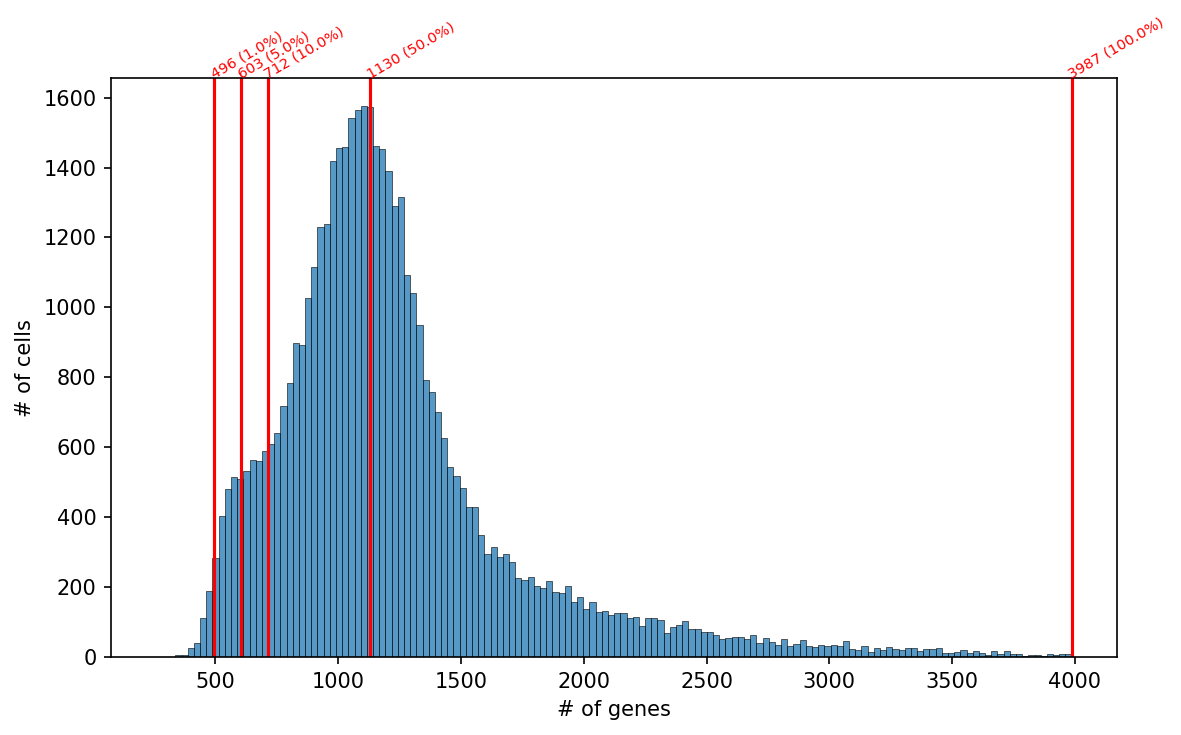

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)

# histogram of number of genes per cell
sns.histplot(nGenesDetectedPerCell, bins='fd', kde=False, ax=ax)

# add vertical lines for chosen percentiles
for i, x in enumerate(percentiles):
    ax.axvline(x=x, ymin=0, ymax=1, color='red')
    # if percentiles is a Series with index in [0.25, 0.5, 0.75], this works:
    pct_label = percentiles.index[i] if hasattr(percentiles, "index") else i
    ax.text(
        x, ax.get_ylim()[1], 
        s=f'{int(x)} ({pct_label*100}%)',
        color='red', rotation=30, size='x-small',
        rotation_mode='anchor'
    )

ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()
plt.show()

## similar dist

This step moves from “Which TFs regulate which genes?” → to “How active is each TF’s regulon in each individual cell?”


In [ ]:
!pyscenic aucell \
    /u/scratch/p/priyalsh/dropbox_oct6/filtered_scenic_cd4_rest_oct6.loom \
    /u/scratch/p/priyalsh/dropbox_oct6/regulons_cd4_rest_oct7.csv \
    --output /u/scratch/p/priyalsh/dropbox_oct6/pyscenic_output_withregulons_cd4_rest_oct7.loom \
    --num_workers 20

## Visualization of SCENIC's AUC matrix

In [38]:
import loompy as lp
import pandas as pd
import json, zlib, base64

f_pyscenic_output = "/u/scratch/p/priyalsh/dropbox_oct6/aucell_oct14.loom"
f_scenic_umap = "scenic_umap.txt"
f_scenic_tsne = "scenic_tsne.txt"


In [40]:
import pandas as pd
import umap
from sklearn.manifold import TSNE

# --- UMAP ---
umap_model = umap.UMAP(
    n_neighbors=10,
    min_dist=0.4,
    metric='correlation',
    random_state=0
)
dr_umap = umap_model.fit_transform(auc_mtx)

pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv("scenic_umap.txt", sep='\t')

# --- t-SNE ---
tsne_model = TSNE(
    n_jobs=20,
    random_state=0
)
dr_tsne = tsne_model.fit_transform(auc_mtx)

pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv("scenic_tsne.txt", sep='\t')


/u/home/p/priyalsh/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/u/home/p/priyalsh/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Integrate the output

In [41]:
# --- Scenic output ---
lf = lp.connect(f_pyscenic_output, mode='r+', validate=False)

# Load MetaData JSON block
meta = json.loads(zlib.decompress(base64.b64decode(lf.attrs.MetaData)))

# Properly unpack RegulonsAUC structured array into a DataFrame
auc_dtype = lf.ca['RegulonsAUC'].dtype
auc_mtx = pd.DataFrame(
    {name: lf.ca['RegulonsAUC'][name] for name in auc_dtype.names},
    index=lf.ca['CellID']
)

# Load regulon structured array
regulons = lf.ra['Regulons']

# Load precomputed UMAP and t-SNE embeddings
dr_umap = pd.read_csv('scenic_umap.txt', sep='\t', header=0, index_col=0)
dr_tsne = pd.read_csv('scenic_tsne.txt', sep='\t', header=0, index_col=0)

lf.close()

print("AUC matrix:", auc_mtx.shape)
print("UMAP:", dr_umap.shape, "t-SNE:", dr_tsne.shape)


AUC matrix: (47630, 103)
UMAP: (47630, 2) t-SNE: (47630, 2)


In [42]:
# --- Clean regulon names for SCope compatibility ---

# 1. Clean AUC matrix column names (replace "(" with "_(")
auc_mtx.columns = auc_mtx.columns.str.replace(r'\(', '_(', regex=True)

# 2. Clean regulon names in the structured array dtype
regulons.dtype.names = tuple([x.replace("(", "_(") for x in regulons.dtype.names])

# 3. Clean regulon names in regulonThresholds metadata
if 'regulonThresholds' in meta:
    rt = meta['regulonThresholds']
    for x in rt:
        x['regulon'] = x['regulon'].replace("(", "_(")


In [43]:
# --- Concatenate embeddings (UMAP + t-SNE) ---

# Ensure dr_umap and dr_tsne match the CellIDs order
cell_ids = auc_mtx.index  # or lf.ca['CellID']

# X coordinates (UMAP X, t-SNE X)
Embeddings_X = pd.concat([
    dr_umap.loc[cell_ids, 'X'],
    dr_tsne.loc[cell_ids, 'X']
], axis=1)
Embeddings_X.columns = ['1', '2']  # 1 = UMAP, 2 = t-SNE

# Y coordinates (UMAP Y, t-SNE Y)
Embeddings_Y = pd.concat([
    dr_umap.loc[cell_ids, 'Y'],
    dr_tsne.loc[cell_ids, 'Y']
], axis=1)
Embeddings_Y.columns = ['1', '2']


In [49]:
import numpy as np
import loompy as lp

# Make sure Leiden is string or int (not categorical)
leiden_values = adata.obs['leiden'].astype(str).values

with lp.connect(f_pyscenic_output, mode='r+', validate=False) as lf:
    # Sanity check: same cell count
    assert len(leiden_values) == lf.ca['CellID'].shape[0], "Cell counts don't match between adata and loom!"
    lf.ca['Leiden'] = leiden_values


In [50]:
with lp.connect(f_pyscenic_output, mode='r', validate=False) as lf:
    print("Leiden column added:", 'Leiden' in lf.ca.keys())
    print("Unique Leiden values:", set(lf.ca['Leiden']))


Leiden column added: True
Unique Leiden values: {np.str_('2'), np.str_('7'), np.str_('1'), np.str_('5'), np.str_('11'), np.str_('3'), np.str_('0'), np.str_('9'), np.str_('10'), np.str_('8'), np.str_('4'), np.str_('6')}


In [52]:
# Clusterings section
metaJson["clusterings"] = [{
    "id": 0,
    "group": "Scanpy",
    "name": "Leiden Clusters",
    "clusters": []
}]

leiden_values = adata.obs['leiden'].astype(int)
n_clusters = leiden_values.max() + 1

for i in range(n_clusters):
    clustDict = {
        "id": i,
        "description": f"Leiden Cluster {i}"
    }
    metaJson['clusterings'][0]['clusters'].append(clustDict)


In [53]:
import numpy as np
import json
import zlib
import base64
import loompy as lp

# --- Build MetaData JSON ---
metaJson = {}

# 1️⃣ Embeddings section — you have only UMAP (1) and t-SNE (2) from SCENIC AUC
metaJson['embeddings'] = [
    {
        "id": 1,
        "name": "SCENIC AUC UMAP"
    },
    {
        "id": 2,
        "name": "SCENIC AUC t-SNE"
    }
]

# 2️⃣ Clusterings section — use Leiden as your main clustering
metaJson["clusterings"] = [{
    "id": 0,
    "group": "SCENIC",
    "name": "Leiden Clusters",
    "clusters": []
}]

# Build cluster list from Leiden values in the loom file
with lp.connect(f_pyscenic_output, mode='r', validate=False) as lf:
    leiden_values = lf.ca['Leiden']

leiden_values = np.array(leiden_values, dtype=int)
n_clusters = leiden_values.max() + 1

for i in range(n_clusters):
    clustDict = {
        "id": i,
        "description": f"Leiden Cluster {i}"
    }
    metaJson['clusterings'][0]['clusters'].append(clustDict)

# 3️⃣ Metrics section — keep nGene and nUMI
metaJson["metrics"] = [
    {"name": "nUMI"},
    {"name": "nGene"}
]

# 4️⃣ Annotations section — use the actual .ca fields: Leiden, CD_Status, Stimulation
with lp.connect(f_pyscenic_output, mode='r', validate=False) as lf:
    cd_status_values = lf.ca['CD_Status']
    stimulation_values = lf.ca['Stimulation']

metaJson["annotations"] = [
    {
        "name": "Leiden",
        "values": list(set(leiden_values.astype(str)))
    },
    {
        "name": "CD_Status",
        "values": list(set(cd_status_values.astype(str)))
    },
    {
        "name": "Stimulation",
        "values": list(set(stimulation_values.astype(str)))
    }
]


In [54]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr


In [60]:
# --- Column attributes ---
col_attrs = {
    # Basic cell info
    "CellID": np.array(adata.obs.index),
    "nUMI": np.array(adata.obs['nUMI'].values),
    "nGene": np.array(adata.obs['nGene'].values),

    # Your categorical annotations from .ca
    "CD_Status": np.array(adata.obs['CD_Status'].astype(str).values),
    "Stimulation": np.array(adata.obs['Stimulation'].astype(str).values),

    # Leiden cluster IDs
    "Leiden": np.array(adata.obs['leiden'].astype(str).values),

    # Embeddings (tSNE, UMAP, etc.)
    "Embedding": dfToNamedMatrix(dr_tsne),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),

    # Regulons AUC matrix as structured array
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),

}

# --- Row attributes ---
row_attrs = {
    "Gene": gene_attr,
    "Regulons": regulons_attr
}

# --- Global attributes ---
attrs = {
    "title": "CD4_Rest_Sample_SCENIC",
    "Genome": "hg38",
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": "",
    "MetaData": base64.b64encode(
        zlib.compress(json.dumps(metaJson).encode('ascii'))
    ).decode('ascii')
}


In [61]:

f_final_loom = f"/u/scratch/p/priyalsh/dropbox_oct6/FINAL_INTEGRATED_OCT14.loom"

# --- Create final SCope-compatible loom ---
with lp.connect(f_pyscenic_output, mode='r', validate=False) as lf:
    lp.create(
        filename=f_final_loom,
        layers=lf[:, :],        # copy the expression matrix
        row_attrs=row_attrs,
        col_attrs=col_attrs,
        file_attrs=attrs
    )

print(f"✅ Final SCope-compatible loom created at:\n{f_final_loom}")


✅ Final SCope-compatible loom created at:
/u/scratch/p/priyalsh/dropbox_oct6/FINAL_INTEGRATED_OCT14.loom
